# specMACS cloud geometry

In the following, an example of how to use the specMACS cloud geometry dataset will be shown. 
The cloud geometry is retrieved by a stereographic feature matching method described by {cite:t}`Koelling:2019`.
The algorithm is applied to the data of the two polarization resolving cameras of the instrument covering a large combined field of view of about $\pm 45° \times \pm 59°$ (along track $\times$ across track) {cite:p}`Poertge:2023`. It is important to mention that no points found does not necessarily mean that no cloud has been observed as this can also happen if the cloud lacks in contrasts or due to a bad tracking of features.

## Open dataset
The cloud geometry data were calculated for each of the flight segments flown by HALO seperately, thus data access will be per `segment_id`.
The flight segmentation can be found in the respective [github repository](https://github.com/eurec4a/flight-phase-separation/).
In this example, we'll have a look at the cloud geometry of the straight leg segment `HALO-0205_sl1` flown on 2020-02-05.
If you don't know your favourite flight segment already or want to query or loop over multiple segments, please have a look at [flight segmentation usage](flight-phase-operations.md).

In [1]:
import eurec4a

segment_id = "HALO-0205_sl1"
cat = eurec4a.get_intake_catalog()
ds = cat.HALO.specMACS.cloud_geometry[segment_id].to_dask()
ds

/usr/share/miniconda3/envs/how_to_eurec4a/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 220MB
Dimensions:             (sample: 2392497, v: 3)
Dimensions without coordinates: sample, v
Data variables:
    time                (sample) datetime64[ns] 19MB ...
    lat                 (sample) float64 19MB ...
    lon                 (sample) float64 19MB ...
    height              (sample) float64 19MB ...
    height_above_geoid  (sample) float64 19MB ...
    loc                 (sample, v) float64 57MB ...
    viewpoint           (sample, v) float64 57MB ...
    max_misspointing    (sample) float32 10MB ...
Attributes:
    _NCProperties:                   version=2,netcdf=4.7.3,hdf5=1.10.4
    title:                           Stereographic retrieved cloud geometry b...
    institution:                     Meteorological Institut, Ludwig-Maximili...
    source:                          specMACS polcameras
    history:                         Created 2023-05-13T18:57:20
    references:                      Kölling, T., Zinner, T., and Mayer, B.: ...
    comment:                         This dataset contains stereographically ...
    contact:                         Lea Volkmer, L.Volkmer@physik.uni-muench...
    DODS_EXTRA.Unlimited_Dimension:  sample

## Simple plots

We will start to do some first simple scatter plots of the cloud top heights (CTH). There are two CTH variables in the dataset: A normal 'height' variable and a variable called 'height_above_geoid'. The first is defined with respect to the WGS84 ellipsoid and the second with respect to the EGM2008 geoid. Although there is not a large difference between both in the EUREC4A area, we will exemplarily plot both.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

We'll select only every 100th data point for a quick overview.

```{important}
Depending on the clouds there might be a lot of points in the dataset or not such that this step might be useful or not.
```

In [3]:
ds_sel = ds.isel(sample=slice(0, None, 100))

load the data variables

In [4]:
lat = ds_sel['lat'].values
lon = ds_sel['lon'].values
height = ds_sel['height'].values
height_above_geoid = ds_sel['height_above_geoid'].values

In [5]:
cmap = 'OrRd'
vmin = np.min([height, height_above_geoid])
vmax = np.max([height, height_above_geoid])

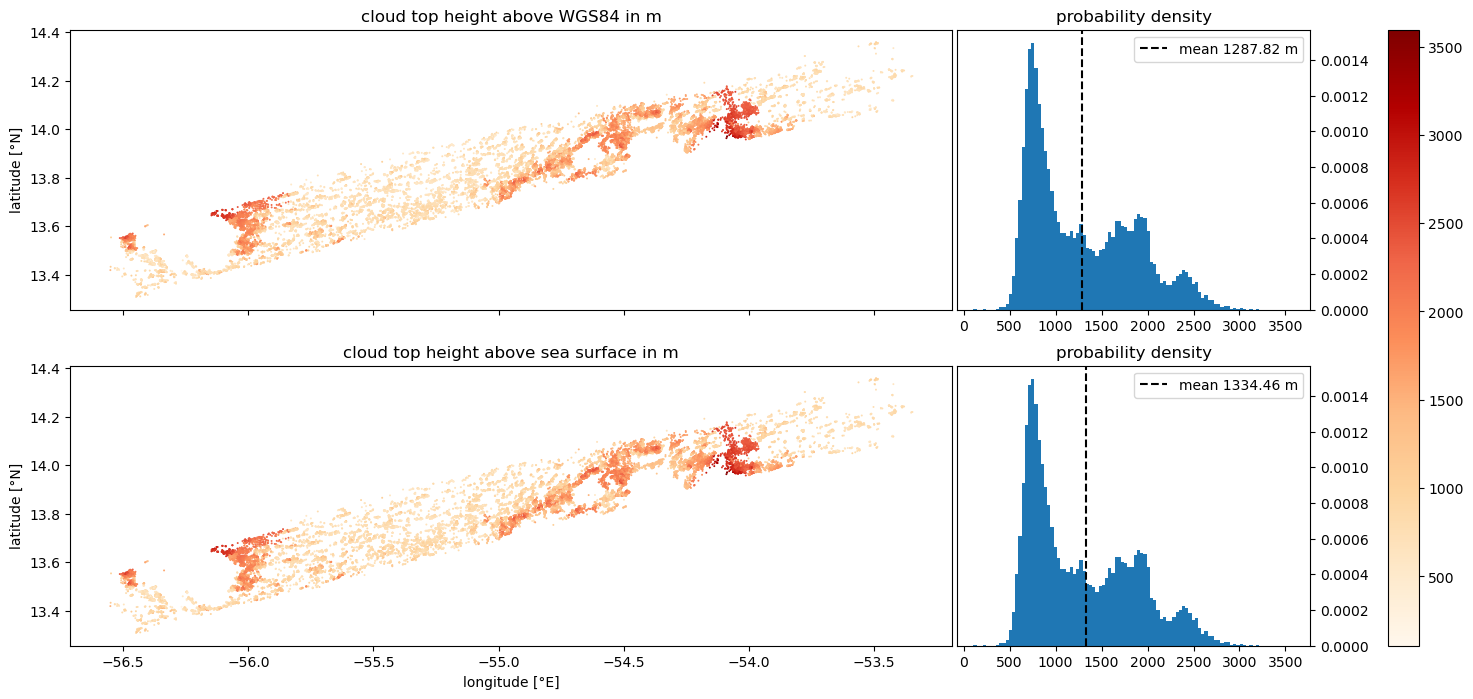

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 8), sharex=True)
for ax, var, ref in zip(axs, [height, height_above_geoid], ["WGS84", "sea surface"]):
    sm = ax.scatter(lon, lat, c=var, marker='o', s=2, edgecolor=None, linewidth=0, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(f'cloud top height above {ref} in m')
    ax.set_ylabel('latitude [°N]')
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes('right', size='40%', pad=0.05)
    ax2.hist(height, bins=100, range=(vmin, vmax), density=True)
    ax2.set_title('probability density')
    ax2.yaxis.tick_right()
    ax2.axvline(np.mean(var), linestyle='dashed', color='k', label='mean {:.2f} m'.format(np.mean(var)))
    ax2.legend()

axs[1].set_xlabel('longitude [°E]')
plt.colorbar(sm, ax=axs)
None

## Make a 3D plot

As the stereo points are points on the cloud surface located in 3D space, we can also do a 3D plot. We will use a few different viewing settings, which can also be individually adjusted using the `elev` and `azim` arguments of the `ax.view_init` setting.

In [7]:
import matplotlib.ticker as ticker

settings for plots

In [8]:
markersize = 0.1
cmap = 'viridis' #colormap
vmin = np.min(height)
vmax = np.max(height)

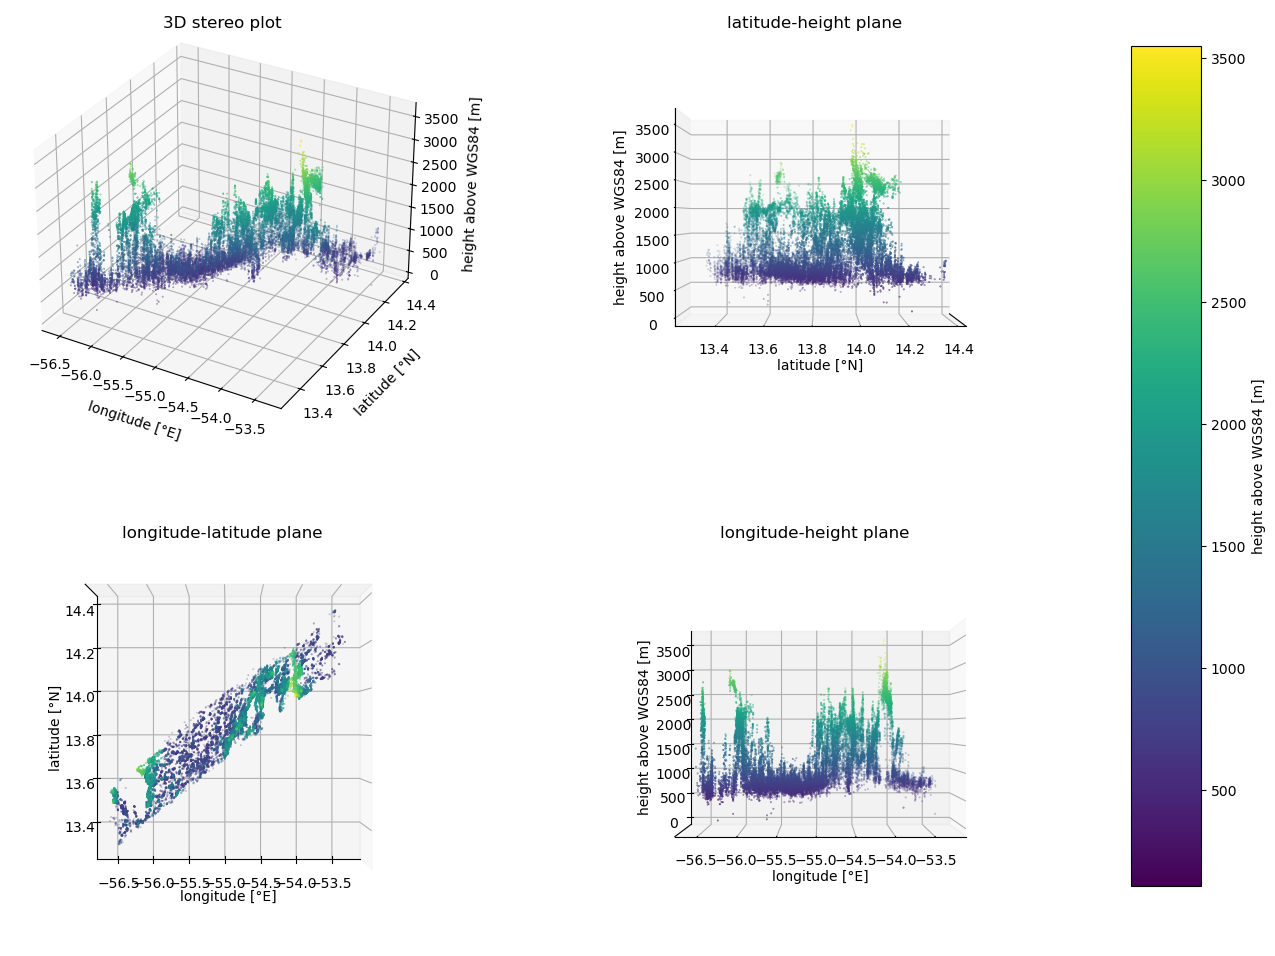

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(14,12), subplot_kw=dict(projection='3d'))

for ax in axs.ravel():
    sm = ax.scatter(lon, lat, height, c=height, marker='o', vmin=vmin, vmax=vmax, cmap=cmap, s=markersize, linewidths=None, edgecolors=None)

ax = axs[0,0]
ax.set_xlabel('longitude [°E]', labelpad=6.0)
ax.set_ylabel('latitude [°N]', labelpad=6.0)
ax.set_zlabel('height above WGS84 [m]', labelpad=6.0)
ax.view_init(elev=None, azim=None)
ax.set_title('3D stereo plot', y=1.02)

ax = axs[0,1]
ax.set_ylabel('latitude [°N]', labelpad=6.0)
ax.set_zlabel('height above WGS84 [m]', labelpad=6.0)
ax.view_init(elev=0, azim=0)
ax.set_title('latitude-height plane', y=1.02)
ax.xaxis.set_major_locator(ticker.NullLocator())

ax = axs[1,0]
ax.set_xlabel('longitude [°E]', labelpad=4.0)
ax.set_ylabel('latitude [°N]', labelpad=6.0)
ax.view_init(elev=90, azim=-90)
ax.set_title('longitude-latitude plane', y=1.02)
ax.zaxis.set_major_locator(ticker.NullLocator())

ax = axs[1,1]
ax.set_xlabel('longitude [°E]', labelpad=6.0)
ax.set_zlabel('height above WGS84 [m]', labelpad=10.0)
ax.view_init(elev=0, azim=-90)
ax.set_title('longitude-height plane', y=1.02)
ax.yaxis.set_major_locator(ticker.NullLocator())

plt.subplots_adjust(bottom=0.1, right=0.9)
cax = plt.axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(sm, cax=cax, label='height above WGS84 [m]', fraction=0.02, shrink=2.0, aspect=40)
None

The 3D plots show the scene from different perspectives. It can be seen that the tracking algorithm finds points in both cloud layers down to a base height of approximately 1000m. Below, there are also some points which are probably outliers due to some wrong identifications.

## Project points to specMACS measurements

We will start to project the points found from the stereographic reconstruction to pre-rendered specMACS [tile maps](https://en.wikipedia.org/wiki/Tiled_web_map) which can be found [here](https://macsserver.physik.uni-muenchen.de/campaigns/EUREC4A/maps/).
To make them available to `cartopy`, we need a little helper class `specMACSPTiles`, which mainly takes care of making unavailable tiles transparent (these are outside the viewing range of the instrument).

In [10]:
from cartopy.io.img_tiles import GoogleWTS
from PIL import Image

class specMACSPTiles(GoogleWTS):
    def __init__(self, flight_segment_id):
        super().__init__(desired_tile_form="RGBA")
        self.flight_segment_id = flight_segment_id
        self.empty_tile = Image.fromarray(np.full((256, 256, 4), (255, 255, 255, 0), dtype=np.uint8))

    def get_image(self, tile):
        from io import BytesIO
        from urllib.request import urlopen, Request, HTTPError, URLError

        url = self._image_url(tile)
        try:
            request = Request(url)
            fh = urlopen(request)
            im_data = BytesIO(fh.read())
            fh.close()
            img = Image.open(im_data)

        except (HTTPError, URLError) as err:
            img = self.empty_tile

        img = img.convert(self.desired_tile_form)
        return img, self.tileextent(tile), 'lower'

    def _image_url(self, tile):
        x, y, z = tile
        return f"https://macsserver.physik.uni-muenchen.de/campaigns/EUREC4A/maps/tiles/{self.flight_segment_id}/{z}/{x}/{y}.png"

We can now get the tile map for our selected flight segment:

In [11]:
specmacs = specMACSPTiles(segment_id)

Get `vmin` and `vmax` using quantiles such that outliers will not influence the colorbar too much:

In [12]:
q = 0.01
vmin, vmax = np.quantile(height, [q, 1-q])
cmap = 'OrRd'

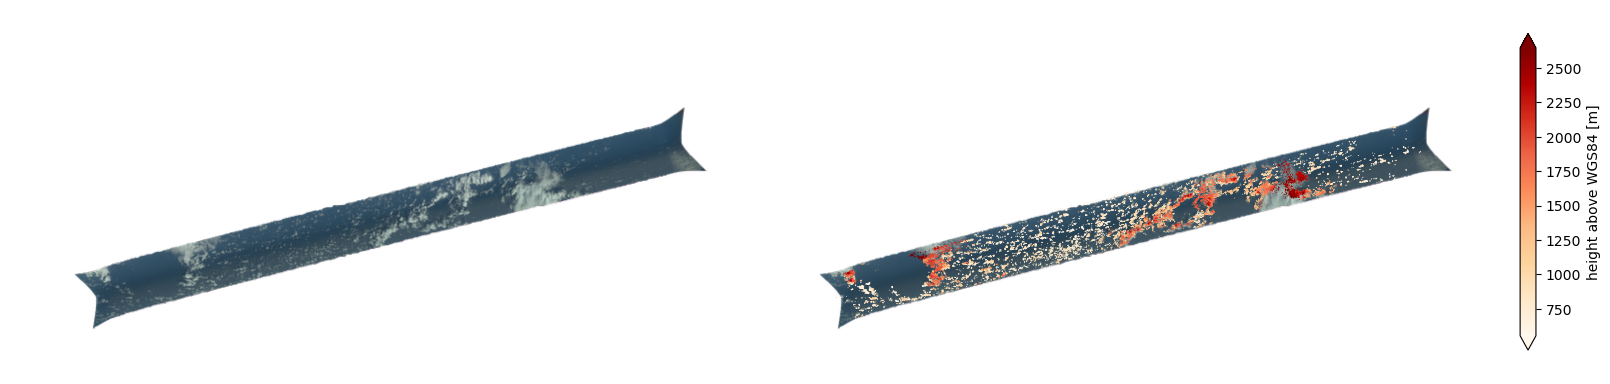

In [13]:
import cartopy.crs as ccrs

fig, axes = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True, subplot_kw={"projection": ccrs.PlateCarree()})
for ax in axes:
    ax.set_extent([np.floor(np.min(lon)), np.ceil(np.max(lon)), np.floor(np.min(lat)), np.ceil(np.max(lat))], crs=ccrs.PlateCarree())
    ax.add_image(specmacs, 8)  # the number is an integer and represents the detail level. It is logarithmic, small values are coarse, large values are fine.
    ax.set_axis_off()
im = ax.scatter(lon, lat, c=height, marker="o", s=0.4, edgecolor=None, linewidth=0, vmin=vmin, vmax=vmax, cmap=cmap)
fig.colorbar(im, label='height above WGS84 [m]', extend='both', shrink=0.4)
None

The projection of the points to the specMACS map on the right shows that most of the clouds, in particular the small cumulus clouds are well identified and located by the stereographic reconstruction method. The only exception is the higher and thicker cloud toward the end of the leg. This cloud lacks contrasts such that only its edges are identified well by the tracking algorithm.